In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

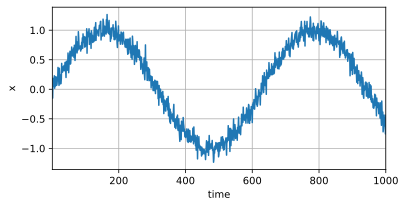

In [6]:
T =1000
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time)+torch.normal(0,0.1,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [12]:
tau = 4
features = torch.zeros((T - tau, tau))
print("features' shape : ",features.shape)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
print("labels' shape : ",labels.shape)

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)

features' shape :  torch.Size([996, 4])
labels' shape :  torch.Size([996, 1])


### 两层的感知机

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [24]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, ' f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net,train_iter,loss,10,0.005)

epoch 1, loss: 0.066220
epoch 2, loss: 0.016600
epoch 3, loss: 0.015331
epoch 4, loss: 0.015315
epoch 5, loss: 0.014613
epoch 6, loss: 0.014342
epoch 7, loss: 0.014378
epoch 8, loss: 0.013885
epoch 9, loss: 0.014227
epoch 10, loss: 0.013834


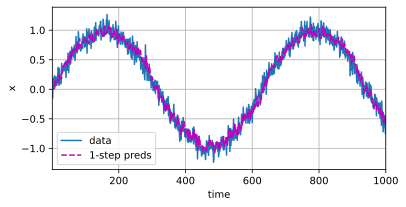

In [25]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

### 和上面不同 预测是由前四个预测数据上预测的 而不是前四个features，所以误差会累积

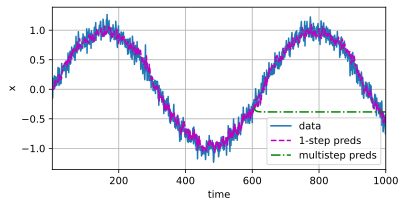

In [26]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

### n-step 就是给你4个点预测未来n个点

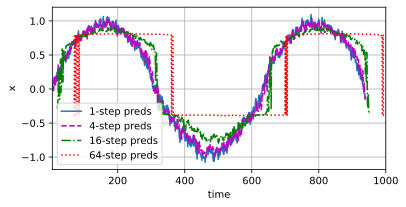

In [27]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))